In [1]:
import pandas as pd
from sqlalchemy import create_engine
import geopandas as gpd

import os

# Database connection details from zshrc environment variables
db_name = 'colorado_spills'
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')


# Create an engine to connect to the PostgreSQL database
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{db_name}')

# Read in the spills_with_demographics as spills
spills = pd.read_sql_table('spills_with_demographics', engine)




In [2]:
# use longitude and latitude to create a GeoDataFrame from spills data
spills['geometry'] = gpd.points_from_xy(spills['Longitude'], spills['Latitude'])

In [3]:
# Create a GeoDataFrame from spills
spills_gdf = gpd.GeoDataFrame(spills, crs='EPSG:4326') 

# Write the GeoDataFrame to a new table in the database
spills_gdf.to_postgis('spills_with_demographics_geog', engine, if_exists='replace')

# Close the database connection
engine.dispose()





In [4]:
from textblob import TextBlob

# Function to get sentiment polarity
def get_sentiment(text):
    blob = TextBlob(text)
    # Polarity ranges from -1 (negative) to +1 (positive)
    return blob.sentiment.polarity

# Apply sentiment analysis to each Spill Description
spills_gdf['Sentiment'] = spills_gdf['Spill Description'].apply(get_sentiment)

# Display the first few sentiment scores
spills_gdf[['Spill Description', 'Sentiment']].head()


,Spill Description,Sentiment
0,Crews working on 6/11/14 in area of former pro...,0.000000
1,Historical release discovered during removal o...,0.000000
2,Historical release discovered during removal o...,0.000000
3,The night operator noticed a high level alarm ...,-0.046667
4,"On May 24, 2014, in anticipation of potential ...",0.151786


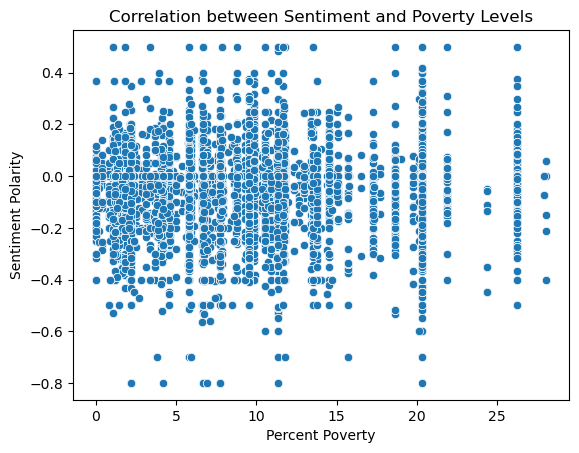

Correlation between sentiment and poverty levels: -0.026246587095843262


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Correlate sentiment with poverty levels
sns.scatterplot(x=spills_gdf['percent_poverty'], y=spills_gdf['Sentiment'])
plt.xlabel('Percent Poverty')
plt.ylabel('Sentiment Polarity')
plt.title('Correlation between Sentiment and Poverty Levels')
plt.show()

# Calculate correlation coefficient
correlation = spills_gdf['percent_poverty'].corr(spills_gdf['Sentiment'])
print(f"Correlation between sentiment and poverty levels: {correlation}")
